# Import Libraries 

In [1]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# Read Data 
Time series deals with 2 columns, one is temporal ie: quarter in this case & another is the value to be forecasted ie: cococola sales. To make plotting graphs easier, we set the index of pandas dataframe to the quarter. During plots, the index will act by default as the x-axis & since it has only 1 more column, that will be automatically taken as the y-axis

In [102]:
dataset = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
dataset.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [31]:
#dataset['Date'] = pd.to_datetime(dataset['Quarter']).dt.to_period('Q')
#dataset

In [103]:
dataset['Quarter'] = (pd.PeriodIndex(dataset.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1'), freq='Q')
   .strftime('%b-%Y'))
dataset.head()

C:\Users\esati\AppData\Local\Temp\ipykernel_7620\1703432952.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['Quarter'] = (pd.PeriodIndex(dataset.Quarter.str.replace(r'(Q\d)_(\d+)', r'19\2-\1'), freq='Q')


,Quarter,Sales
0,Mar-1986,1734.827000
1,Jun-1986,2244.960999
2,Sep-1986,2533.804993
3,Dec-1986,2154.962997
4,Mar-1987,1547.818996


In [104]:
#dataset['Quarter'] = pd.to_datetime(dataset['Quarter']) #convert from string to datetime

indexedDataset = dataset.set_index(['Quarter'])
indexedDataset.head(5)

,Sales
Quarter,
Mar-1986,1734.827000
Jun-1986,2244.960999
Sep-1986,2533.804993
Dec-1986,2154.962997
Mar-1987,1547.818996


From the plot below, we can see that there is a Trend compoenent in th series. Hence, we now check for stationarity of the data

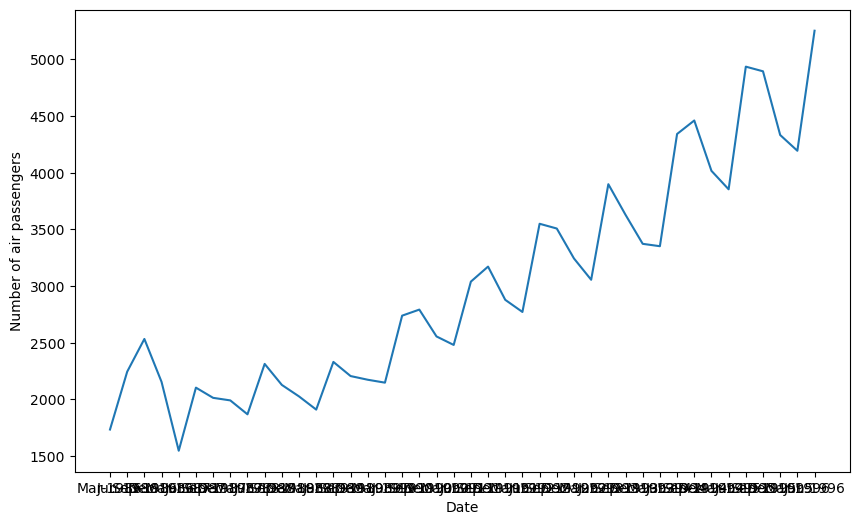

In [83]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedDataset)

In [84]:
#Determine rolling statistics
rolmean = indexedDataset.rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

                Sales
Quarter              
Mar-1986          NaN
Jun-1986          NaN
Sep-1986          NaN
Dec-1986          NaN
Mar-1987          NaN
Jun-1987          NaN
Sep-1987          NaN
Dec-1987          NaN
Mar-1988          NaN
Jun-1988          NaN
Sep-1988          NaN
Dec-1988  2055.393998
Mar-1989  2070.042081
Jun-1989  2077.225747
Sep-1989  2049.954497
Dec-1989  2051.538247
Mar-1990  2101.576497
Jun-1990  2154.484497
Sep-1990  2219.350414
Dec-1990  2266.372330
Mar-1991  2317.365997
Jun-1991  2377.856914
Sep-1991  2464.839913
Dec-1991  2535.854247
Mar-1992  2607.637247
Jun-1992  2709.206831
Sep-1992  2817.660998
Dec-1992  2906.818665
Mar-1993  2982.462165
Jun-1993  3079.103165
Sep-1993  3148.790332
Dec-1993  3216.872832
Mar-1994  3289.458332
Jun-1994  3397.998082
Sep-1994  3505.405083
Dec-1994  3600.238333
Mar-1995  3690.404999
Jun-1995  3805.904999
Sep-1995  3921.488333
Dec-1995  4012.250000
Mar-1996  4107.083333
Jun-1996  4219.916667                Sales
Quarter    

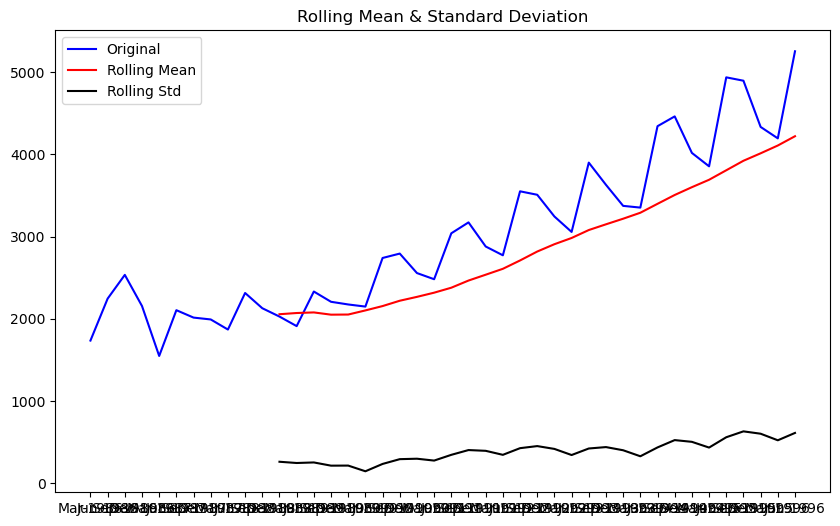

In [85]:
#Plot rolling statistics
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

To further augment our hypothesis that the time series is not stationary, let us perform the ADCF test.



In [86]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(indexedDataset['Sales'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)


Results of Dickey Fuller Test:
Test Statistic                  1.309421
p-value                         0.996661
#Lags Used                      7.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


For a Time series to be stationary, its ADCF test should have:

p-value to be low (according to the null hypothesis)
The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics
From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary

# Data Transformation to achieve Stationarity

There are a couple of ways to achieve stationarity through data transformation like taking  𝑙𝑜𝑔10 , 𝑙𝑜𝑔𝑒 , square, square root, cube, cube root, exponential decay, time shift and so on ...

In our notebook, lets start of with log transformations. Our objective is to remove the trend component. Hence, flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.

# Log Scale Transformation 

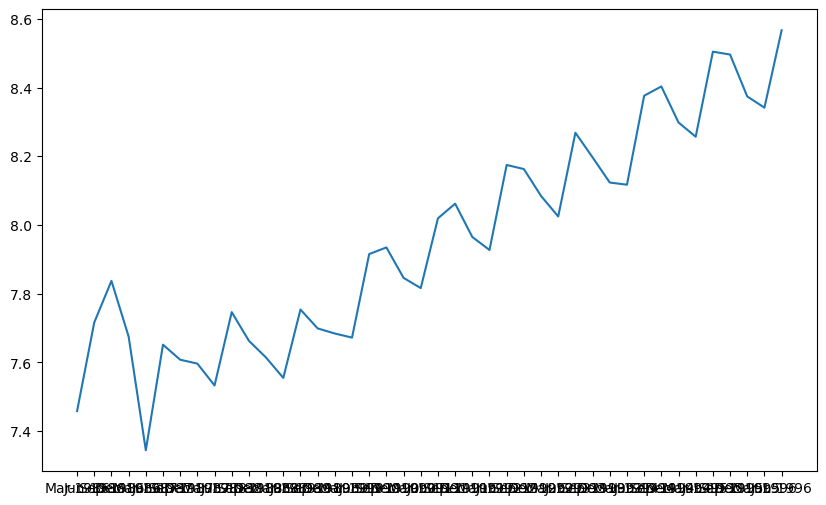

In [87]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

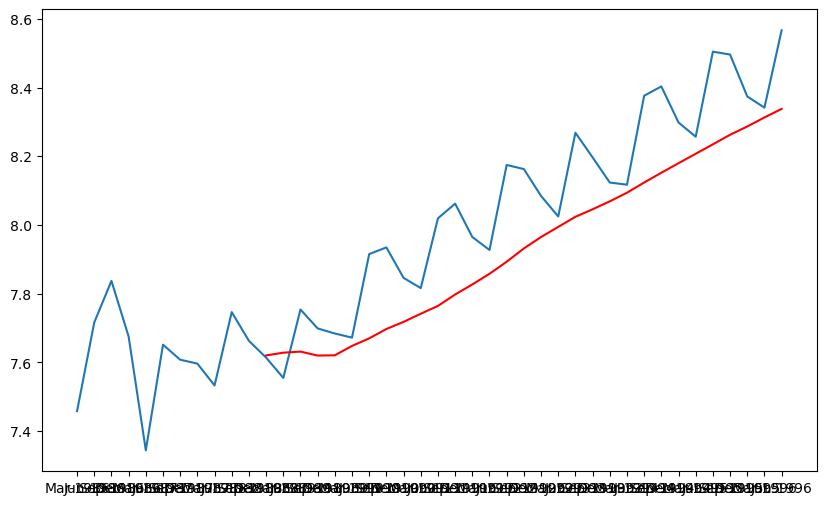

In [88]:
#The below transformation is required to make series stationary
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case, where no transfromation were applied to series. So we can atleast say that we are heading in the right direction.

We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:

𝑙𝑜𝑔𝑠𝑐𝑎𝑙𝑒𝐿=𝑠𝑡𝑎𝑡𝑖𝑜𝑛𝑎𝑟𝑦𝑝𝑎𝑟𝑡(𝐿1)+𝑡𝑟𝑒𝑛𝑑(𝐿𝑇) 
𝑚𝑜𝑣𝑖𝑛𝑔𝑎𝑣𝑔𝑜𝑓𝑙𝑜𝑔𝑠𝑐𝑎𝑙𝑒𝐴=𝑠𝑡𝑎𝑡𝑖𝑜𝑛𝑎𝑟𝑦𝑝𝑎𝑟𝑡(𝐴1)+𝑡𝑟𝑒𝑛𝑑(𝐴𝑇) 
𝑟𝑒𝑠𝑢𝑙𝑡𝑠𝑒𝑟𝑖𝑒𝑠𝑅=𝐿−𝐴=(𝐿1+𝐿𝑇)−(𝐴1+𝐴𝑇)=(𝐿1−𝐴1)+(𝐿𝑇−𝐴𝑇) 
Since, L & A are series & it moving avg, their trend will be more or less same, Hence
LT-AT nearly equals to 0

Thus trend component will be almost removed. And we have,

𝑅=𝐿1−𝐴1 , our final non-trend curve

In [89]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Sales
Quarter,
Dec-1988,-0.006306
Mar-1989,-0.073402
Jun-1989,0.122407
Sep-1989,0.078993
Dec-1989,0.063385
Mar-1990,0.024180
Jun-1990,0.245246
Sep-1990,0.237342
Dec-1990,0.127975


In [90]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(dataset['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

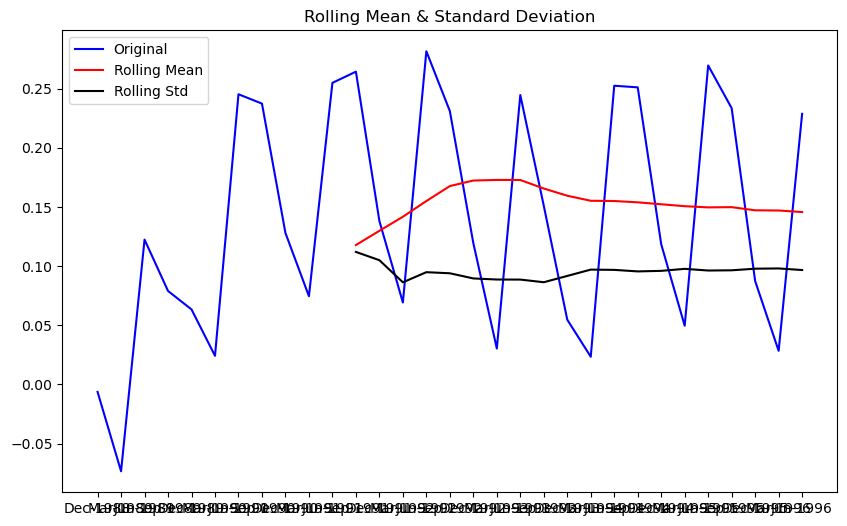

Results of Dickey Fuller Test:
Test Statistic                  1.309421
p-value                         0.996661
#Lags Used                      7.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


In [91]:
test_stationarity(datasetLogScaleMinusMovingAverage)

From above graph, we observe that our intuition that *"subtracting two related series having similar trend components will make the result stationary"* is true. We find that:

p-value has reduced from 0.99 to 0.006.
The critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic. Thus, from above 2 points, we can say that our given series is stationary.
But, in the spirit of getting higher accuracy, let us explore & try to find a better scale than our current log.

Let us try out Exponential decay.


# Exponential Decay Transformation 

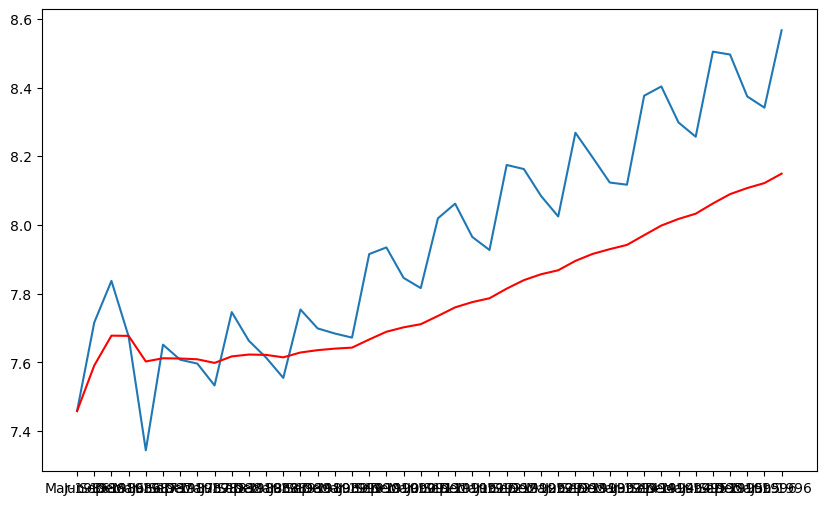

In [92]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

From above graph, it seems that exponential decay is not holding any advantage over log scale as both the corresponding curves are similar. But, in statistics, inferences cannot be drawn simply by looking at the curves. Hence, we perform the ADCF test again on the decay series below.

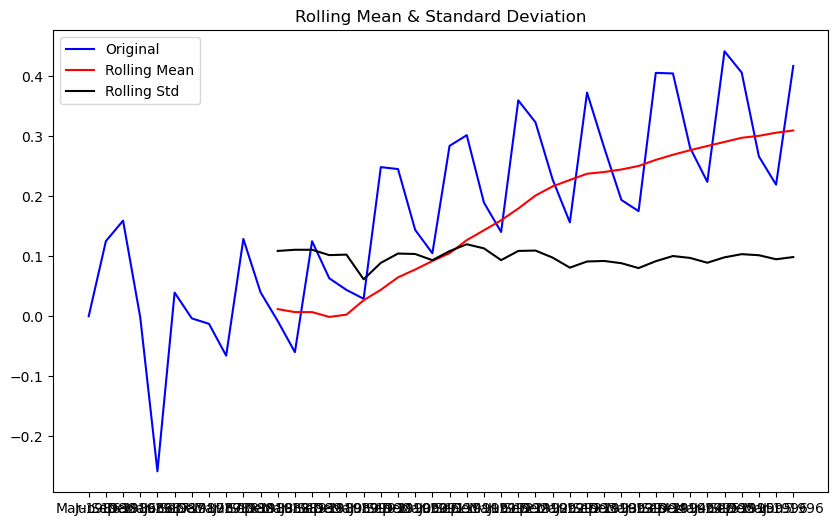

Results of Dickey Fuller Test:
Test Statistic                  1.309421
p-value                         0.996661
#Lags Used                      7.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


In [93]:
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

We observe that the Time Series is stationary & also the series for moving avg & std. dev. is almost parallel to x-axis thus they also have no trend.
Also,

1.p-value has increased from 0.006 to 0.388.
2.Test Statistic value is not very much closer to the Critical values.
Both the points say that our current transformation is not better than the previous logarithmic transformation. Even though, we couldn't observe any differences by visually looking at the graphs, the tests confirmed logarithmic to be  much better.
But lets try one more time & find if an even better solution exists. We will try out the simple time shift technique, which is simply:

Given a set of observation on the time series:
𝑥0,𝑥1,𝑥2,𝑥3,....𝑥𝑛 

The shifted values will be:
𝑛𝑢𝑙𝑙,𝑥0,𝑥1,𝑥2,....𝑥𝑛  <---- basically all xi's shifted by 1 pos to right

Thus, the time series with time shifted values are:
𝑛𝑢𝑙𝑙,(𝑥1−𝑥0),(𝑥2−𝑥1),(𝑥3−𝑥2),(𝑥4−𝑥3),....(𝑥𝑛−𝑥𝑛−1)

# Time Shift Transformation 

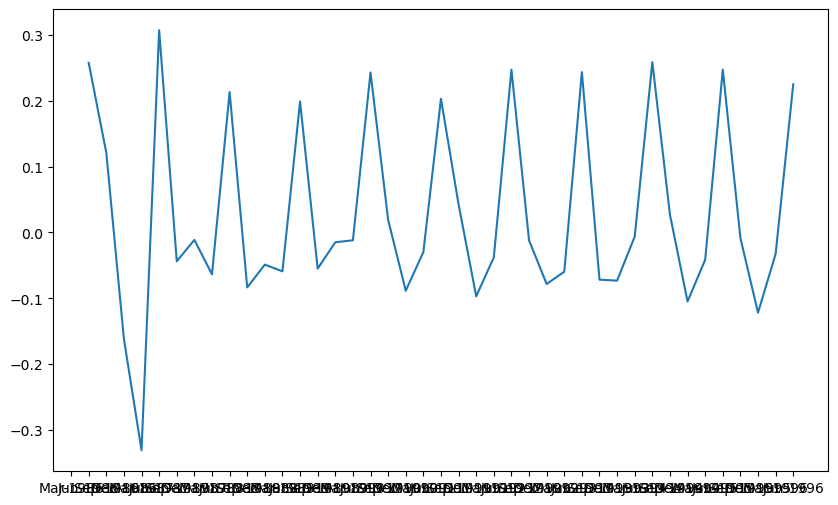

In [94]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

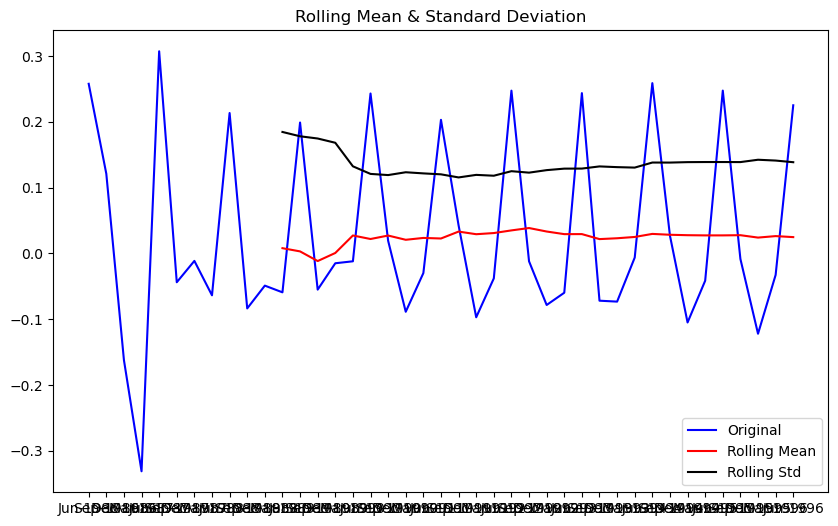

Results of Dickey Fuller Test:
Test Statistic                  1.309421
p-value                         0.996661
#Lags Used                      7.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


In [95]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. But, the ADCF test shows us that:

1.p-value of 0.02 is not as good as 0.006 of Log scale transformation.
2.Test Statistic value not as close to the critical values as that for Log scale transformation .
We have thus tried out 3 different transformation: log, exp decay & time shift. For simplicity, we will go with the log scale. The reason for doing this is that we can revert back to the original scale during forecasting.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.

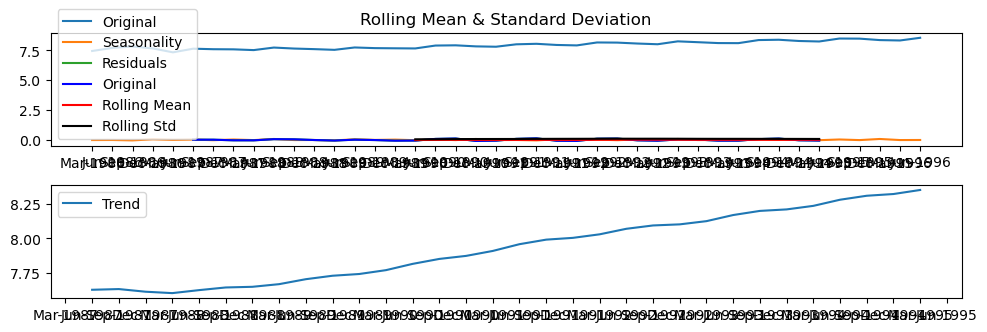

Results of Dickey Fuller Test:
Test Statistic                  1.309421
p-value                         0.996661
#Lags Used                      7.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


In [106]:
decomposition = seasonal_decompose(indexedDataset_logScale,period=10) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consisted of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

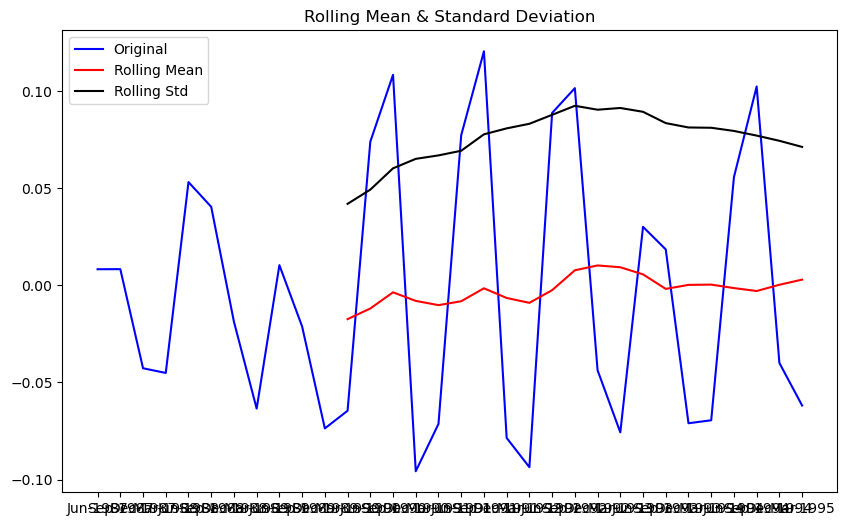

Results of Dickey Fuller Test:
Test Statistic                  1.309421
p-value                         0.996661
#Lags Used                      7.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


In [107]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

# Plotting ACF & PACF 

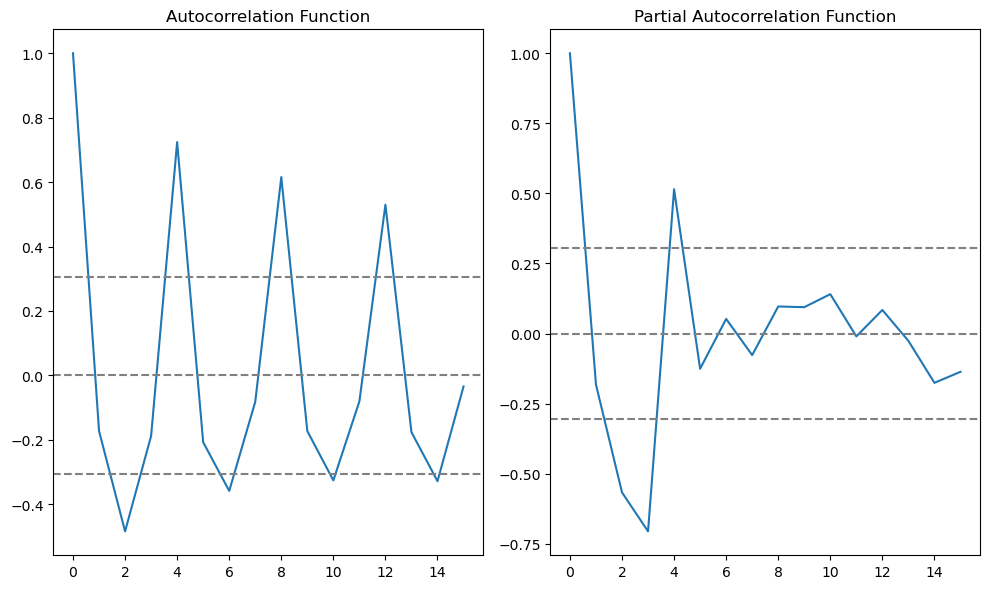

In [108]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=15)
lag_pacf = pacf(datasetLogDiffShifting, nlags=15, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

From the ACF graph, we see that curve touches y=0.0 line at x=1. Thus, from theory, Q = 1 From the PACF graph, we see that curve touches y=0.0 line at x=1. Thus, from theory, 1 = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

# Building Models

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Plotting AR model


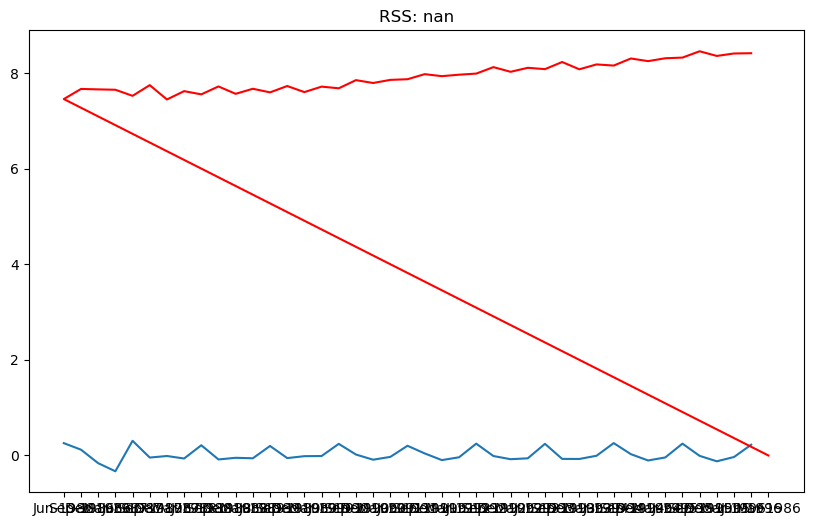

In [110]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(indexedDataset_logScale, order=(2,1,0))
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Sales'])**2))
print('Plotting AR model')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


Plotting MA model


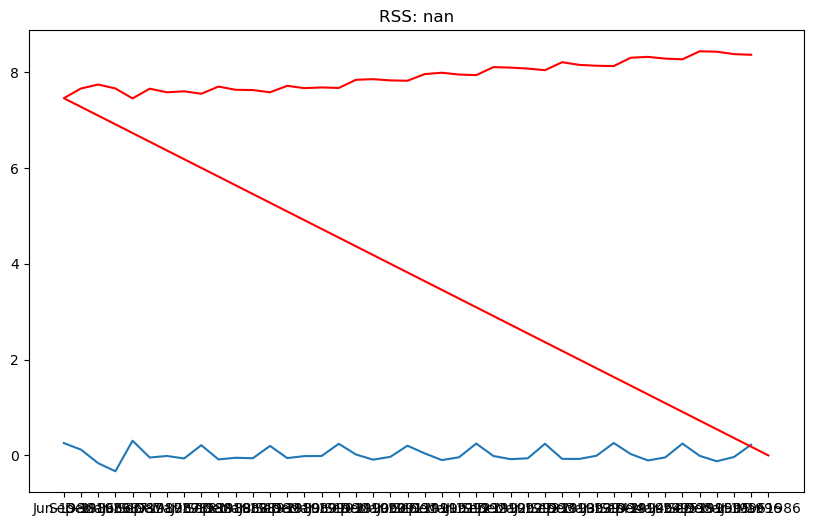

In [111]:
#MA Model
model = ARIMA(indexedDataset_logScale, order=(0,1,2))
results_MA = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['Sales'])**2))
print('Plotting MA model')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Plotting ARIMA model


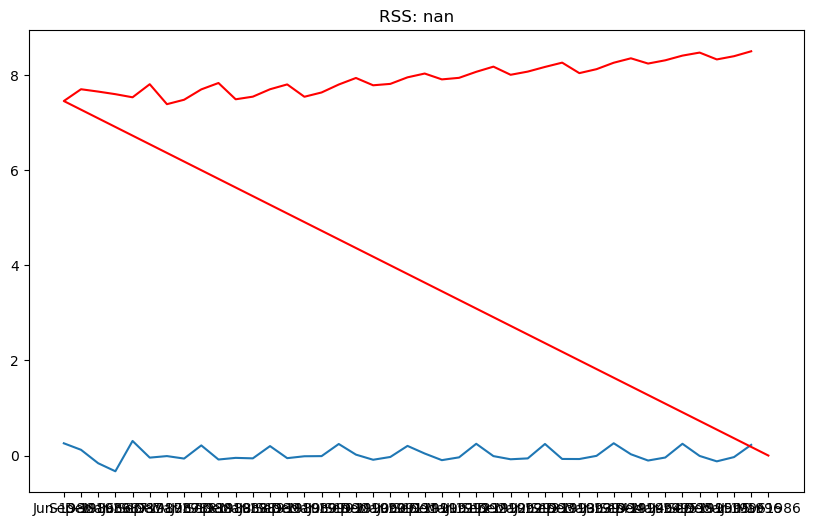

In [112]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['Sales'])**2))
print('Plotting ARIMA model')

By combining AR & MA into ARIMA, we see that RSS value has decreased from either case , indicating ARIMA to be better than its individual component models.

With the ARIMA model built, we will now generate predictions. But, before we do any plots for predictions ,we need to reconvert the predictions back to original form. This is because, our model was built on log transformed data.

# Prediction & Reverse transformations

In [113]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Quarter
Mar-1986    0.000000
Jun-1986    7.458663
Sep-1986    7.706584
Dec-1986    7.657291
Mar-1987    7.602687
dtype: float64


In [114]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

Quarter
Mar-1986      0.000000
Jun-1986      7.458663
Sep-1986     15.165247
Dec-1986     22.822537
Mar-1987     30.425224
Jun-1987     37.962296
Sep-1987     45.774435
Dec-1987     53.166755
Mar-1988     60.652363
Jun-1988     68.355887
Sep-1988     76.193789
Dec-1988     83.688962
Mar-1989     91.239480
Jun-1989     98.945801
Sep-1989    106.753903
Dec-1989    114.302343
Mar-1990    121.941098
Jun-1990    129.746993
Sep-1990    137.690674
Dec-1990    145.480450
Mar-1991    153.299649
Jun-1991    161.256560
Sep-1991    169.293466
Dec-1991    177.207362
Mar-1992    185.153753
Jun-1992    193.227092
Sep-1992    201.408960
Dec-1992    209.419732
Mar-1993    217.497556
Jun-1993    225.673486
Sep-1993    233.939674
Dec-1993    241.985156
Mar-1994    250.114096
Jun-1994    258.378351
Sep-1994    266.735777
Dec-1994    274.982742
Mar-1995    283.298131
Jun-1995    291.712184
Sep-1995    300.189971
Dec-1995    308.523761
Mar-1996    316.925474
Jun-1996    325.430695
dtype: float64


In [115]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Sales'].iloc[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Quarter
Mar-1986     7.458663
Jun-1986    14.917326
Sep-1986    22.623910
Dec-1986    30.281200
Mar-1987    37.883887
dtype: float64

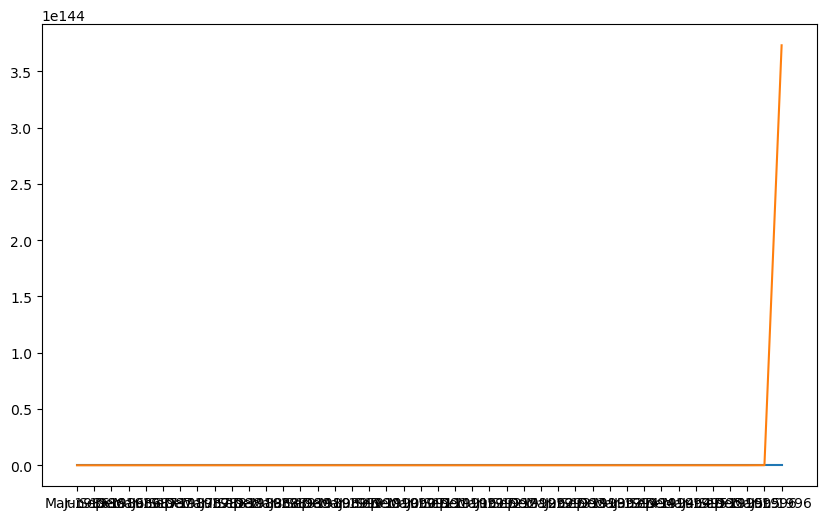

In [116]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

We see that our predicted forecasts are close to the real time series values indicating a fairly accurate model.

In [117]:
indexedDataset_logScale

,Sales
Quarter,
Mar-1986,7.458663
Jun-1986,7.716443
Sep-1986,7.837477
Dec-1986,7.675529
Mar-1987,7.344602
Jun-1987,7.651791
Sep-1987,7.608058
Dec-1987,7.596767
Mar-1988,7.533186


In [119]:
results_ARIMA.predict(1,264) 


1986-06-01    7.458663
1986-09-01    7.706584
1986-12-01    7.657291
1987-03-01    7.602687
1987-06-01    7.537072
                ...   
2051-03-01    8.474593
2051-06-01    8.369057
2051-09-01    8.463321
2051-12-01    8.565532
2052-03-01    8.468025
Freq: QS-DEC, Name: predicted_mean, Length: 264, dtype: float64